In [424]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import imageio
from numba import njit
from ipywidgets import interact, interactive
from scipy.signal import peak_widths, find_peaks
from scipy.interpolate import CubicSpline

plt.rcParams.update({"font.size" : 16, "font.family" : "serif", "figure.figsize" : (8,8)})

In [425]:
@njit
def energy(field, J, pos):
    i, j = pos
    m = J.shape[0]
    n = field.shape[0]
    energy = 0
    
    for a in range(m):
        for b in range(m):
            energy += J[a, b]*field[(i+a-m//2)%n, (j+b-m//2)%n]
    energy *= field[i,j]
    
    return energy


@njit
def ising_simulation_random(field, J, T=1.0, maxiter=int(1e7)):
    #init
    n = field.shape[0]
    
    #to flip or not to flip
    rand_positions = np.random.randint(low=0, high=n, size=2*maxiter).reshape(-1, 2)
    rand_decision = np.random.random(maxiter)
    
    #probabilities
    probs = np.random.random(maxiter)

    #Ising steps, Monte-Carlo
    for idx in range(maxiter):
        i, j = rand_positions[idx]
        E = energy(field, J, [i, j])

        #Monte-Carlo single-flip step
        if E > 0 or rand_decision[idx] < np.exp(2*E/T):
            field[i, j] = -field[i, j]
                
    return field


def corr2d(field):
    n = field.shape[0]
    temp = np.fft.fft2(field)
    res = np.real(np.fft.ifft2(temp * np.conjugate(temp)))
    res /= np.max(res)
    res = np.vstack((np.hstack((res[n//2:, n//2:], res[n//2:, :n//2])), np.hstack((res[:n//2, n//2:], res[:n//2, :n//2]))))
    
    res_slice = res[::,n//2]
    cs1 = CubicSpline(np.arange(0, len(res_slice),2), res_slice[::2])
    cs2 = CubicSpline(np.arange(1, len(res_slice),2), res_slice[1::2])
    res_slice1 = cs1(np.arange(len(res_slice)))
    res_slice2 = cs2(np.arange(len(res_slice)))
    
    res_slice = np.max(np.vstack([res_slice1, res_slice2]), axis=0)
    
    return res_slice


def corr_diam(field):
    temp = corr2d(field)
    peaks, _ = find_peaks(temp, height=0.75)
    results_half = peak_widths(temp, peaks, rel_height=0.5)
    return results_half[0][0]

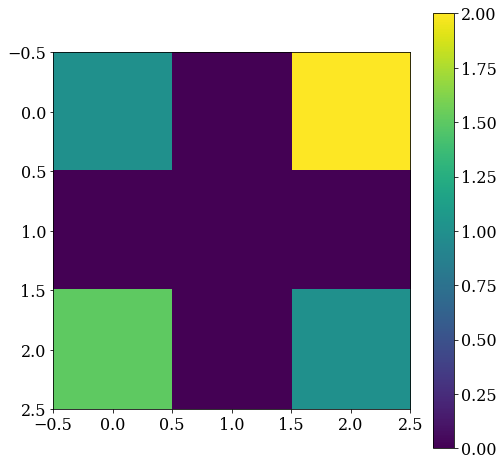

In [426]:
m = 3
J = np.zeros((m, m))
x, y = np.arange(m), np.arange(m)
xx, yy = np.meshgrid(x, y)
J[0, 0] = 1
J[-1, -1] = 1
J[0, -1] = 2
J[-1, 0] = 1.5


n = 350
field = np.random.choice([1,-1],p=[0.5,0.5], size=(n,n))
plt.imshow(J)
plt.colorbar()

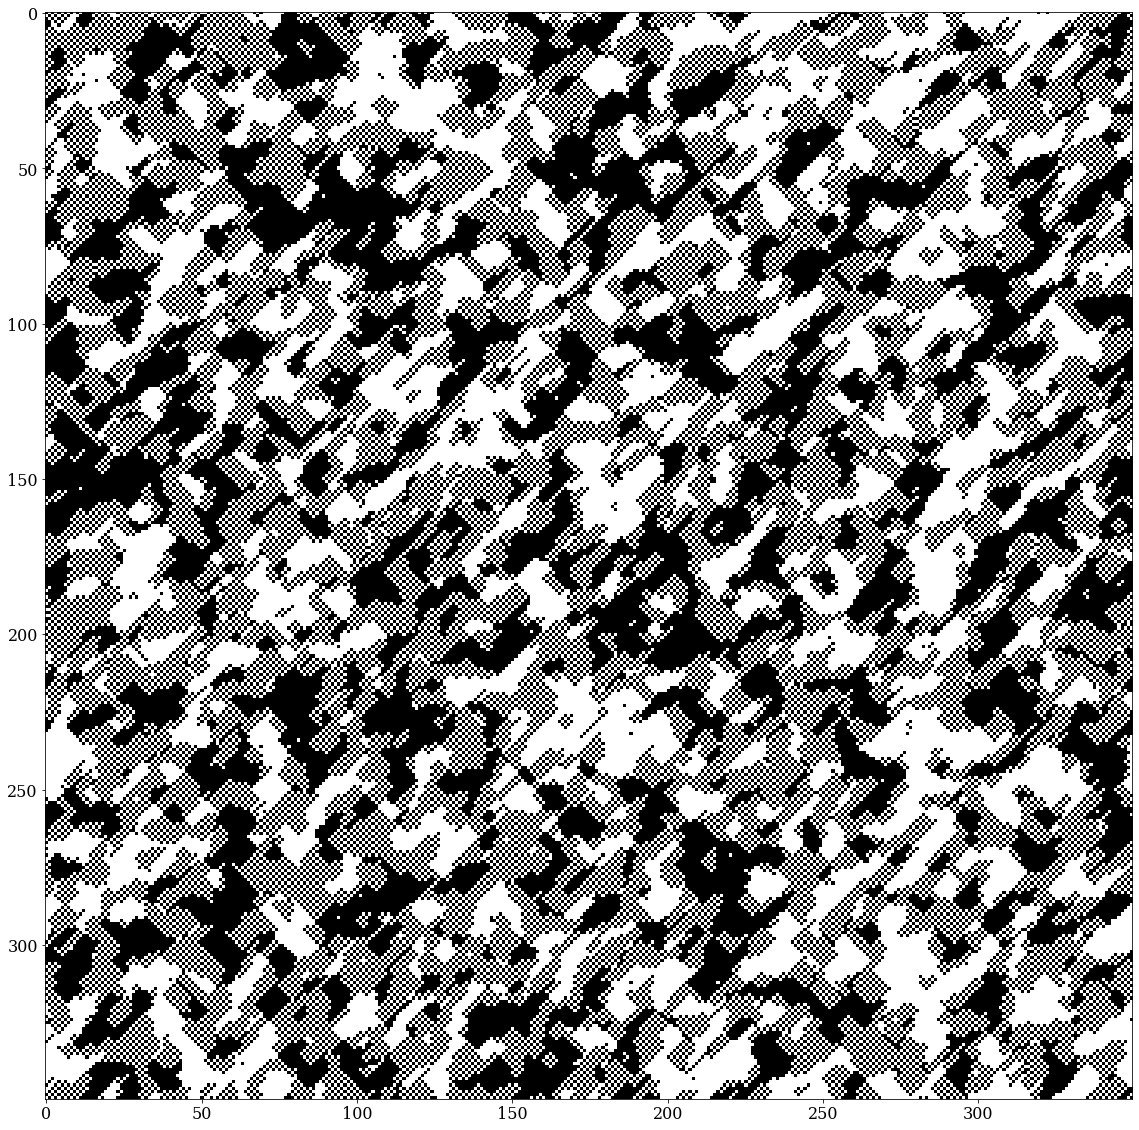

In [427]:
field = ising_simulation_random(field, J=-J, T=0.5, maxiter=int(1e6))
plt.figure(figsize=(20, 20))
plt.imshow(field, cmap='binary')

### Snezhinki

In [465]:
from scipy.signal import convolve2d

In [446]:
def neighbours(n, i,j):
    return [[(i - 1)%n, j%n], [(i + 1)%n, j%n], [i, (j-1)%n], [i%n, (j+1)%n]]


In [483]:
beta = 0.5
gamma = 1e-2
n = 11

vertices = np.array([[i, j] for i in range(n) for j in range(n)])
kernel = np.array([[0, 1/8, 0], [1/8, 1/2, 1/8], [0, 1/8, 0]])


state = np.zeros((n, n))
state[0, ::] = beta
state[-1, ::] = beta
state[::, 0] = beta
state[::, -1] = beta

padding = np.argwhere(state == beta)
vertices = vertices[~np.isin(vertices, padding)]

 
#parasha?!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
temp_state = np.copy(state)


state += beta
state[n//2, n//2] =  5

receptive = np.argwhere(state >= 1.0)
# print(receptive)
receptive = receptive[~np.isin(receptive, padding)]
print(receptive)

temp = []
for idx in receptive:
    i, j = idx
    temp.append(neighbours(n, i, j))
receptive = np.append(receptive, temp)

nonreceptive = vertices[~np.isin(vertices, receptive)]

temp_state[receptive] = 0.0
temp_state = convolve2d(state, kernel, mode='same')

state += gamma
state[nonreceptive] = 0.0
state += temp_state




plt.imshow(state, vmin=0.0, vmax=1.0, cmap='binary')
plt.colorbar()

[]


IndexError: arrays used as indices must be of integer (or boolean) type

In [459]:
a = np.arange(5)
b = np.arange(3)


a[~np.isin(a, b)]

array([3, 4])

In [477]:
receptive

array([], dtype=float64)

In [482]:
padding

array([[ 0,  0],
       [ 0,  1],
       [ 0,  2],
       [ 0,  3],
       [ 0,  4],
       [ 0,  5],
       [ 0,  6],
       [ 0,  7],
       [ 0,  8],
       [ 0,  9],
       [ 0, 10],
       [ 1,  0],
       [ 1, 10],
       [ 2,  0],
       [ 2, 10],
       [ 3,  0],
       [ 3, 10],
       [ 4,  0],
       [ 4, 10],
       [ 5,  0],
       [ 5, 10],
       [ 6,  0],
       [ 6, 10],
       [ 7,  0],
       [ 7, 10],
       [ 8,  0],
       [ 8, 10],
       [ 9,  0],
       [ 9, 10],
       [10,  0],
       [10,  1],
       [10,  2],
       [10,  3],
       [10,  4],
       [10,  5],
       [10,  6],
       [10,  7],
       [10,  8],
       [10,  9],
       [10, 10]])